# Tensorflow Probability Demonstration

In this notebook, we will first use xgboost to build a model for the classcal boston house price dataset. It turns out that there is a greater limitation on dealing with extrapoloation using xgboost (i.e. predicting the samples that are outside the value range of the training sample)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Dropout

In [2]:
data_dict = fetch_california_housing(data_home=os.getcwd())
data_raw = pd.DataFrame(np.hstack([data_dict['data'], data_dict['target'].reshape(-1,1)]), 
                    columns=np.hstack([data_dict['feature_names'], data_dict['target_names']]))
data = data_raw.copy()

In [3]:
data = pd.concat([data, pd.get_dummies(data['Latitude'].astype(int).astype(str), drop_first=True, prefix='Latitude')], axis=1)
data = pd.concat([data, pd.get_dummies(data['Longitude'].astype(int).astype(str), drop_first=True, prefix='Longitude')], axis=1)

To demonstrate the limitation on extrapolation, we purposely put the data into testing dataset when the target value is greater than a certain threshold. 

Training dataset shape: (16804, 28)
Testing dataset shape: (3836, 28)
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-17 21:25:53.648790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-17 21:25:53.648883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


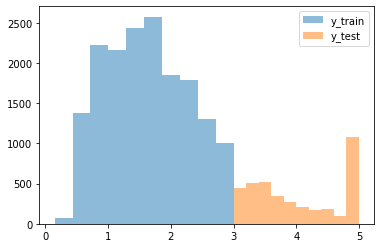

In [4]:
data_train = data[data['MedHouseVal'] <=3]
data_test = data[data['MedHouseVal'] >3]
print('Training dataset shape: ' + str(data_train.shape))
print('Testing dataset shape: ' + str(data_test.shape))
X_train, y_train = data_train.drop('MedHouseVal', axis=1), data_train['MedHouseVal']
X_test, y_test = data_test.drop('MedHouseVal', axis=1), data_test['MedHouseVal']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(256).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(256).batch(128)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.legend(['y_train', 'y_test'])

Let's build a very basic neural network to predict the price of the house price and look at the prediction result when the training set has a target value range that does not overlap with the target data set.

In [5]:
class NNRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NNRegressor, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='relu')
        self.dropout1 = Dropout(0.3)
        self.dense2 = Dense(8, activation='relu')
        self.dropout2 = Dropout(0.3)
        self.dense3 = Dense(4, activation='relu')
        self.dropout3 = Dropout(0.3)
        self.dense4 = Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        output = self.dense4(x)
        return output

model_nn = NNRegressor()
model_nn.compile(optimizer='adam', loss='mse')
history_nn = model_nn.fit(train_ds, validation_data=test_ds, epochs=50, verbose=0)

2022-07-17 21:25:54.033893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-17 21:25:54.034027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-17 21:25:55.174515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-07-17 21:26:35.246279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


nn mse 3.7091


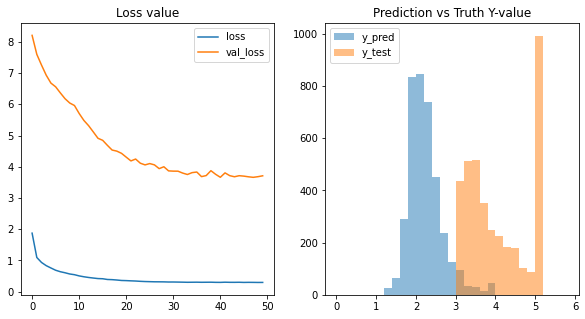

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history_nn.history['loss'])
ax[0].plot(history_nn.history['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[0].set_title('Loss value')

plot_range = np.arange(0,6,0.2)
y_pred_nn = model_nn.predict(X_test, verbose=0)
ax[1].hist(y_pred_nn, alpha=0.5, bins=plot_range)
ax[1].hist(y_test, alpha=0.5, bins=plot_range)
ax[1].legend(['y_pred', 'y_test'])
ax[1].set_title('Prediction vs Truth Y-value')
print('nn mse {:.4f}'.format(mean_squared_error(y_test, y_pred_nn)))

The training set has no target value greater than 3, 
it is very fair that the model prediction did very bad on target values above 3.
## Probabilistic neural network
Recall that in a linear regression model, $y = mx+c+ \epsilon$, we use the data to find the slope $m$ and intercept $c$. <br>
The error $\epsilon$ is assume to be with mean $0$ and variance $\sigma$. <br>
It is very natural to ask, even though the prediction value $\hat{y}=mx+c$ mainly fall below $3$, if we include the stochastic error term $\epsilon$, is it possible to have a higher portion of predictions that are above $3$?

In the following cell, we try apply the above idea. At the very beginning, our network prediction is deterministic, which is similar to what the $\hat{y}$ does. Now we add an extra node to estimate the value $\sigma$, and each time when we predict a value, apart from producing the value $\hat{y}$, we randomly pick a value from $N(0, \sigma)$ so that the prediction now counts the randomness of the unexplained term. 

More precisely, our prediction now goes from a determinstic term $\hat{y}$ to a stochastic term $y \sim N(\hat{y}, \sigma)$.

In [7]:
class TFPRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super(TFPRegressor, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='relu')
        self.dropout1 = Dropout(0.3)
        self.dense2 = Dense(8, activation='relu')
        self.dropout2 = Dropout(0.3)
        self.dense3 = Dense(4, activation='relu')
        self.dropout3 = Dropout(0.3)
        self.mean = Dense(1)
        self.var = Dense(1)
        self.normal =tfp.layers.DistributionLambda(
                      lambda x: tfp.distributions.Normal(loc=x[0],
                                scale=1e-5 + tf.math.softplus(x[1]))) # A normal distribution layer 

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        mean = self.mean(x)
        var = self.var(x) # 
        output = self.normal((mean, var))
        return output
model_tfp = TFPRegressor()
model_tfp.compile(optimizer='adam', loss='mse')
history_tfp = model_tfp.fit(train_ds, validation_data=test_ds, epochs=50, verbose=0)

2022-07-17 21:26:35.988136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-17 21:26:37.162961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-07-17 21:27:30.905161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tfp mse 3.2468


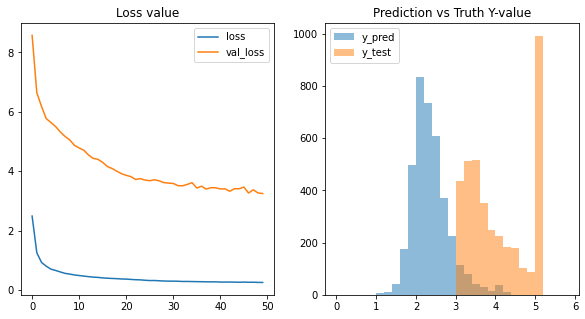

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history_tfp.history['loss'])
ax[0].plot(history_tfp.history['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[0].set_title('Loss value')

plot_range = np.arange(0,6,0.2)
y_pred_tfp = model_tfp.predict(X_test, verbose=0)
ax[1].hist(y_pred_tfp, alpha=0.5, bins=plot_range)
ax[1].hist(y_test, alpha=0.5, bins=plot_range)
ax[1].legend(['y_pred', 'y_test'])
ax[1].set_title('Prediction vs Truth Y-value')
print('tfp mse {:.4f}'.format(mean_squared_error(y_test, y_pred_tfp)))

Depends on the random seed, sometime you may get a result that have a higher portion of values greater than 3. However, as you can imagine, and the mean of the prediction is still $\hat{y}$, which means when you repeat your prediction and take an average of the predictions, the result should be similar to what the we get from the first network. Getting a higher portion of 3 is just by luck!

## Regularization by monte carlo dropout
Let's have another crazy idea, what if we assume further that the weights in the network follow a certain distribution instead of just those target values? That means, we sample the weights from the distribution we predict based on the given input values $x$. 

There is a very simple way to apply this idea. In fact, most of us have already known part of this method - the dropout layer. In the traditional application, we will trun on the randomness of the dropout layer during prediction, but now we keep turning it on. The idea behind is that we assume the weights disbute on 2 points $0$ and the trained weight $\hat{w}$ in the previous epoch. We sample from these two values to generate a randomness on the network weight.  

In [9]:
class BNNRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super(BNNRegressor, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='relu')
        self.dropout1 = Dropout(0.3)
        self.dense2 = Dense(8, activation='relu')
        self.dropout2 = Dropout(0.3)
        self.dense3 = Dense(4, activation='relu')
        self.dropout3 = Dropout(0.3)
        self.dense4 = Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x, training=True)
        x = self.dense2(x)
        x = self.dropout2(x, training=True)
        x = self.dense3(x)
        x = self.dropout3(x, training=True)
        output = self.dense4(x)
        return output

In [10]:
model_bnn = BNNRegressor()
model_bnn.compile(optimizer='adam', loss='mse')
history_bnn = model_bnn.fit(train_ds, validation_data=test_ds, epochs=50, verbose=0)

2022-07-17 21:27:31.701129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-17 21:27:32.577932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-07-17 21:28:12.928830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


bnn mse 3.5953


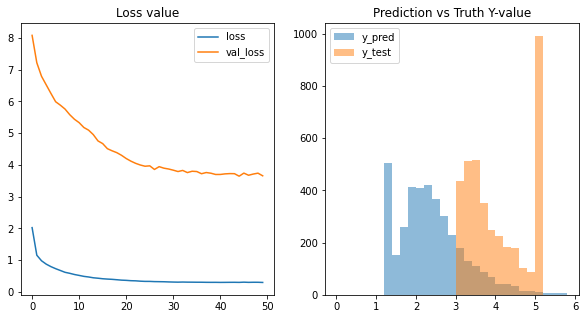

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history_bnn.history['loss'])
ax[0].plot(history_bnn.history['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[0].set_title('Loss value')

plot_range = np.arange(0,6,0.2)
y_pred_bnn = model_bnn.predict(X_test, verbose=0)
ax[1].hist(y_pred_bnn, alpha=0.5, bins=plot_range)
ax[1].hist(y_test, alpha=0.5, bins=plot_range)
ax[1].legend(['y_pred', 'y_test'])
ax[1].set_title('Prediction vs Truth Y-value')
print('bnn mse {:.4f}'.format(mean_squared_error(y_test, y_pred_bnn)))

Lets compare the distribution and the valuation loss across 3 models.

Text(0.5, 1.0, 'Prediction Y-values')

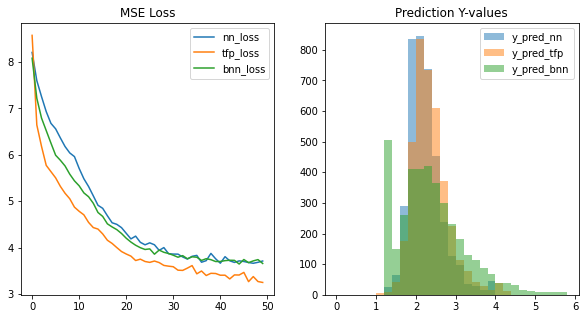

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history_nn.history['val_loss'])
ax[0].plot(history_tfp.history['val_loss'])
ax[0].plot(history_bnn.history['val_loss'])
ax[0].legend(['nn_loss', 'tfp_loss', 'bnn_loss'])
ax[0].set_title('MSE Loss')

plot_range = np.arange(0,6,0.2)
ax[1].hist(y_pred_nn, alpha=0.5, bins=plot_range)
ax[1].hist(y_pred_tfp, alpha=0.5, bins=plot_range)
ax[1].hist(y_pred_bnn, alpha=0.5, bins=plot_range)
ax[1].legend(['y_pred_nn', 'y_pred_tfp', 'y_pred_bnn'])
ax[1].set_title('Prediction Y-values')



Depends on the random seed, even though the average error is comparable to other methods, but it produces a significantly more portion of predictions greater than 3. You may wonder, does the third network

In [13]:
tfp_mean = [model_tfp.predict(X_test, verbose=0)[:,0] for _ in range(100)]
bnn_mean = [model_bnn.predict(X_test, verbose=0)[:,0] for _ in range(100)]

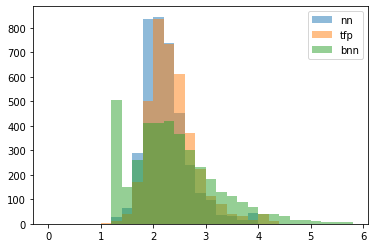

In [14]:
plt.hist(y_pred_nn, alpha=0.5, bins=plot_range)
plt.hist(np.array(tfp_mean).mean(axis=0), alpha=0.5, bins=plot_range)
plt.hist(np.array(bnn_mean).mean(axis=0), alpha=0.5, bins=plot_range)

plt.legend(['nn', 'tfp', 'bnn'])

Apart from assuming the distribution of weight on 2 points, you may also assume them to distribute on random normal and even other fancy distribution. In particular, there is a literature name for network with random normal weight called <i>Variational Inference</i>

## Conclusion and extension
While the above dropout method is pretty simple, there is a more technical motivation to come up this idea.
Have you ever asked why do you add the $L^2$ norm to the loss function of linear regression? Apart from the so called 'panelty on weights', it can be interpreted from the perspective of Bayesian statistics.

The Bayesian statistics always come with a prior distribution (belief) of the parameters and digest the information to produce a posterior distribution (update of the belief). The $L^2$ norm in fact derived from the prior distribution of the parameters. 
Consider the log likehood function of the target $y \sim N(\hat{y}, \sigma)$ with fixed $\sigma$.

$$ \sum log(\frac{1}{\sqrt{2\pi\sigma^2}}) - \sum(\frac{(y_i-mx_i-c)^2}{2\sigma ^2}) $$

To maximize the log likelihood is the same as choosing $m,c$ that minimize $\sum(y_i-mx_i-c)^2 = \sum(y_i - \hat{y})^2$. That is how the cost functions defined. 
 
If we now add a normal prior with zero mean and standard deviation $\sigma$ same as the data  for $m$ and $c$, the posterior of the joint probability of $m, c$ becomes
$$ f(m,c|x) = \frac{f(y|x, m, c)f(m,c|x)}{f(y|x)}$$

Note that denominator does not depend on $m,c$ and the $f(y|x,m,c)$ is just the likehood above. The log posterior (~likehood) added the extra term 
$$ log f(m,c|x) = -\frac{m^2}{2\sigma ^2} - \frac{c^2}{2\sigma ^2}$$
which coincide with the $L^2$ norm in the $L^2$ regularization.

Back to the <b>nerual network</b>, you may notice that in the previous example we imposed a very restrictive constraints on <b>the prior, the error term and the regression formula</b>. In general, it is very difficult to <b>analytically</b> calculate the posterior distribution. Say, how do you know how the thing distribute when is comes with a series of Relu on the linear combination of the <i>Relu</i> of a normal parameter?

The abovementioned <i>variational inference</i> and <i>monte carlo dropout</i> are methods to <b>approximate the posterior</b> of the parameters. Due to the randomness and the limited size of the sample in the data set, the data is 'convincing' to shrink the posterior to a particular range of values, and that is why the third model is able to produce a higher portion of prediction that is greater than 3.